# pysr tutorial, from cosine to rate state friction

In this tutorial we are going to go through first steps of symbolic regression using `pysr`. First we will use a basic example for a cosine function. Then we will use a rate and state friction model. Along the way we will explain how pysr arrives at the functional solution.

Some of this comes from the original tutorial provided by `pysr` which can be found on google colab:

https://colab.research.google.com/github/MilesCranmer/PySR/blob/master/examples/pysr_demo.ipynb#scrollTo=4nDAAnisdhTc

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split
import scipy.integrate as integrate

In [2]:
# Dataset
np.random.seed(0)
X = 2 * np.random.randn(100, 5)
x3 = X[:, 3]
x0 = X[:, 0]
# y = 2.5382 * np.cos(X[:, 3]) + X[:, 0] ** 2 - 2
y = 2.5382 * np.cos(x3) + x0 ** 2 - 2

# explanation how the model works

PySR works, essentially, by creating a decision tree that picks the best set of equations using some loss function (defined by the user), then creates an ensemble of equations that can be estimated based on minimizing both the loss and the complexity.

Below we create a dictionary of the paramaters we want to use in the model.

By default, `populations=15`, but you can set a different number of populations with this option. More populations may increase the diversity of equations discovered, though will take longer to train. However, it is usually more efficient to have `populations>procs`, as there are multiple populations running on each core.

By default, PySRRegressor uses `model_selection='best'` which selects an equation from `PySRRegressor.equations_` using a combination of accuracy and complexity. You can also select `model_selection='accuracy'`.

PySRRegressor scores a model using the following equation:



In [3]:
default_pysr_params = dict(
    populations=30, # https://astroautomata.com/PySR/options/#populations
    model_selection="best",
)

Now we can fit the model. The process works essentially the same as a `sklearn` model. First you create the model object with it's set of hyperparameters. Then you fit the model. Keep in mind that unlike `sklearn`, which is creating a single model, a `PySR` model is technically an ensemble of linear regression models (in the statistical sense, that is, a linear combination of variables as opposed to, for example, a decision tree).

`PySR` can run for arbitrarily long, and continue to find more and more accurate expressions. You can set the total number of cycles of evolution with `niterations`, although there are also a few more ways to stop execution.

Binary operators are operators that include any form of combination, such as `A + B` or `A * B`. https://en.wikipedia.org/wiki/Binary_operation

Unary operators are operators that perform a transformation, as as `sin(x)` or `abs(x)` or `-(x)`.

Note, if operators are not included then they will not be selected for use in the regressor. For example, if you leave out `cos`, the regressor will not be able to try applying a `cos` function in the equations it attempts.

There is a number of predefined operators:

https://astroautomata.com/PySR/operators/

However you can also create custom operators.

You can also automatically generate the model definition with the below tool:

https://astroautomata.com/PySR/interactive-docs/

The best equation is picked using a combination of accuracy (by loss function) and complexity. Complexity is defined by the linear combination of the number of operators used. Each operator is worth 1 complexity. You can set custom complexity values. This combination, called "score" is defined by:

$$ \text{score} = - \log(\text{loss}_i/\text{loss}_{i-1})/
(\text{complexity}_i - \text{complexity}_{i-1})$$

In [4]:
# Learn equations
model = PySRRegressor(
    niterations=30,
    binary_operators=["plus", "mult"],
    unary_operators=["cos", "exp", "sin"],
    **default_pysr_params
)

model.fit(X, y)

/opt/homebrew/anaconda3/envs/symbol/lib/python3.8/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/homebrew/anaconda3/envs/symbol/lib/python3.8/site-packages/pysr/julia_helpers.py:197: UserWarning: Your system's Python library is static (e.g., conda), so precompilation will be turned off. For a dynamic library, try `pyenv`.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	   pick      score                                   equation          loss  \
	0         0.000000                                   2.354772  3.360272e+01   
	1         0.850855                                  (x0 * x0)  6.128181e+00   
	2         0.349618                    ((x0 * x0) + -1.755887)  3.045492e+00   
	3         0.002620     (((x0 * x0) * 0.9776909) + -1.6640462)  3.029573e+00   
	4         0.996444       (((x0 * x0) + cos(x3)) + -1.8519913)  1.118488e+00   
	5         0.161678   (((x0 * x0) + -3.119208) + exp(cos(x3)))  9.515150e-01   
	6  >>>>  28.669862  (((x0 * x0) + (cos(x3) * 2.5382)) + -2.0)  3.367076e-13   
	
	   complexity  
	0           1  
	1           3  
	2           5  
	3           7  
	4           8  
	5           9  
	6          10  
]

Here we see that the regressor correctly picks the training equation: $y = -2 + x_{0}^2 + \cos 2.5382 x_{3}$

We can also print out the functional representation using `sympy` and choosing the equation index.

In [5]:
model.sympy(6)

x0**2 + 2.5382*cos(x3) - 2.0

# now lets try for swinging pendulum

angle $\theta$

angular frequency $\omega$

parameters $c$ and $b$ 

$$ \theta''(t) + \theta'(t) b + c \sin \theta (t) = 0$$

$$ \omega(t) = \theta'(t) $$

$$ \omega'(t) + \omega(t)b + c \sin \theta(t) = 0$$

$$ \omega'(t) = - \omega(t) b - c \sin \theta(t) $$

In [6]:
def pend(y, t, b, c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

In [7]:
b = 0.25
c = 5.0

In [8]:
y0 = [np.pi - 0.1, 0.0]
t = np.linspace(0, 10, 101)

In [9]:
sol = integrate.odeint(pend, y0, t, args=(b, c))
# first column of sol is angle of pendulum theta
# second column of sol is angular velocity omega

In [10]:
theta = sol[:,0]
omega = sol[:,1]

In [38]:
sol[0:5]

array([[ 3.04159265,  0.        ],
       [ 3.03910723, -0.04970768],
       [ 3.03161031, -0.10063956],
       [ 3.01885604, -0.15527321],
       [ 3.00034622, -0.21619767]])

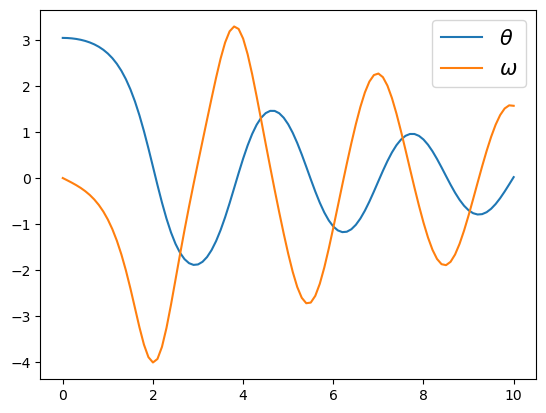

In [11]:
plt.plot(t, theta, label=r'$\theta$')
plt.plot(t, omega, label=r'$\omega$')
plt.legend(fontsize=15)

In [12]:
# we need to get the y side of the equation (in this case the angular acceleration)
omega_prime_t = - b * omega - c * np.sin( theta)

In [13]:
default_pysr_params = dict(
    populations=30, # https://astroautomata.com/PySR/options/#populations
    model_selection="best",
)

In [14]:
model = PySRRegressor(
    niterations=30,
    binary_operators=["plus", "mult"],
    unary_operators=["cos", "exp", "sin"],
    **default_pysr_params
)

model.fit(sol, omega_prime_t)

/opt/homebrew/anaconda3/envs/symbol/lib/python3.8/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!


PySRRegressor.equations_ = [
	   pick      score                                           equation  \
	0         0.000000                                         0.14967948   
	1         0.381557                                  (-1.7381545 * x0)   
	2         3.208693                                (-4.8933 * sin(x0))   
	3         0.013271            (-4.8908224 * (sin(x0) + -0.015237867))   
	4  >>>>  14.555388                  ((sin(x0) * -5.0) + (x1 * -0.25))   
	5         0.043878  ((sin(x0) * -5.0) + ((x1 * 0.8698908) * -0.287...   
	
	           loss  complexity  
	0  1.125061e+01           1  
	1  5.245174e+00           3  
	2  2.119543e-01           4  
	3  2.064027e-01           6  
	4  4.699651e-14           8  
	5  4.304807e-14          10  
]

Where x0 is theta and x1 is omega.

## how close does the model get to reality?

We don't really need to test the model predictions since we see that model 4 is the same equation as our model that created the data but let's do it anyways

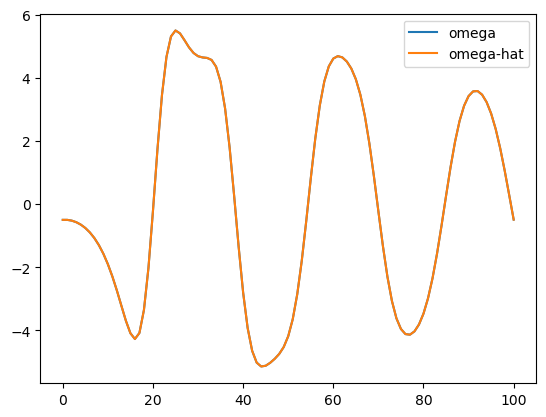

In [15]:
yhat = model.predict(sol)
plt.plot(omega_prime_t)
plt.plot(yhat)
plt.legend(['omega','omega-hat'])

In [16]:
help(model.predict)

Help on method predict in module pysr.sr:

predict(X, index=None) method of pysr.sr.PySRRegressor instance
    Predict y from input X using the equation chosen by `model_selection`.
    
    You may see what equation is used by printing this object. X should
    have the same columns as the training data.
    
    Parameters
    ----------
    X : ndarray | pandas.DataFrame
        Training data of shape `(n_samples, n_features)`.
    index : int | list[int]
        If you want to compute the output of an expression using a
        particular row of `self.equations_`, you may specify the index here.
        For multiple output equations, you must pass a list of indices
        in the same order.
    
    Returns
    -------
    y_predicted : ndarray of shape (n_samples, nout_)
        Values predicted by substituting `X` into the fitted symbolic
        regression model.
    
    Raises
    ------
    ValueError
        Raises if the `best_equation` cannot be evaluated.



In [18]:
# lets make some new data
y0_new = [np.pi-0.01, 0]
sol_new = integrate.odeint(pend, y0_new, t, args=(b, c))

In [19]:
omega_new = sol[:,0]
theta_new = sol[:,1]
omega_prime_t_new = - b * omega_new - c * np.sin(theta_new)

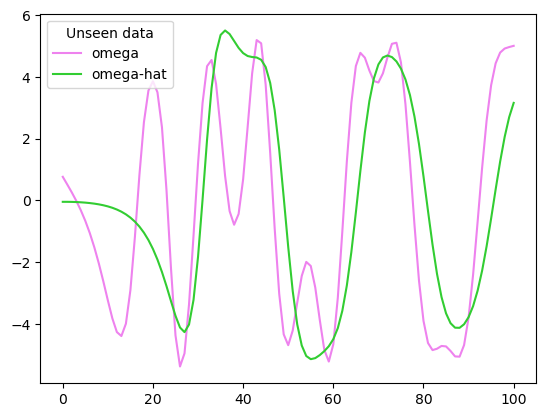

In [20]:
plt.plot(-omega_prime_t_new, color='violet')
plt.plot(model.predict(sol_new), color='limegreen')
plt.legend(['omega', 'omega-hat'], title='Unseen data')


# Next stop rate and state

In [21]:
from dataclasses import dataclass,astuple,asdict # for C-like structure

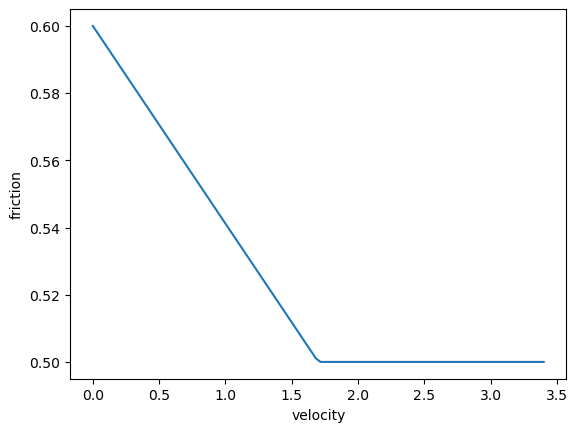

In [22]:
# @dataclass
# class parameters:
#     m    :float = 1 # mass
#     k    :float = .1 # spring stiffness
#     mu_s :float = 0.6
#     mu_d :float = 0.5
#     sn   :float = 1
#     v0   :float = 1.2
#     vmax :float = 1.7

# def friction(vel, mu_d, mu_s, vmax): 
#     vela = np.abs(vel)
#     indpl = np.where(vela>vmax)
#     indps = np.where((vela>0) & (vela <=vmax))

#     fric = np.ones(vela.size) * mu_s
#     for i in indpl:
#         fric[i] = fric[i] - (mu_s-mu_d)
#     for i in indps:
#         fac = vela[i]/vmax
#         fric[i] = fric[i] - fac  * (mu_s - mu_d)
#     return fric 

# # test friction
# par = parameters()      

# vel = np.linspace(0, par.vmax*2, 100)
# fric = friction(vel, par.mu_d, par.mu_s, par.vmax)                  
# plt.plot(vel, fric)
# plt.xlabel('velocity')
# plt.ylabel('friction')
# plt.show()

In [23]:
# def dxdt(x, t, m, k, mu_d, mu_s, smA, v0, vmax):
#     """
#     x    : x position
#     t    : time
#     m    : mass
#     k    : spring konstant
#     mu_d : dynamic friction coefficient
#     mu_s : static friction coefficient
#     smA  : ???
#     v0   : initial velocity
#     vmax : maximum velocity
#     """
#     f0 = x[1]
#     f1 = -(k * (x[0] - t * v0) + np.sign(x[1]) * par.sn * friction([x[1]], mu_d, mu_s, vmax))/m 
#     return [f0, f1]

# def ode_solver_scipy(xInit, t, par):
#     """
#     xInit : x boundary conditions (i.e., minmax(x))
#     t     : time
#     par   : parameters
#     """
#     sol = integrate.odeint(dxdt, xInit, t, astuple(par), rtol=1e-12)
#     return sol

In [24]:
# help(dxdt)

Help on function dxdt in module __main__:

dxdt(x, t, m, k, mu_d, mu_s, smA, v0, vmax)
    x    : x position
    t    : time
    m    : mass
    k    : spring konstant
    mu_d : dynamic friction coefficient
    mu_s : static friction coefficient
    smA  : ???
    v0   : initial velocity
    vmax : maximum velocity



Text(0, 0.5, 'velocity')

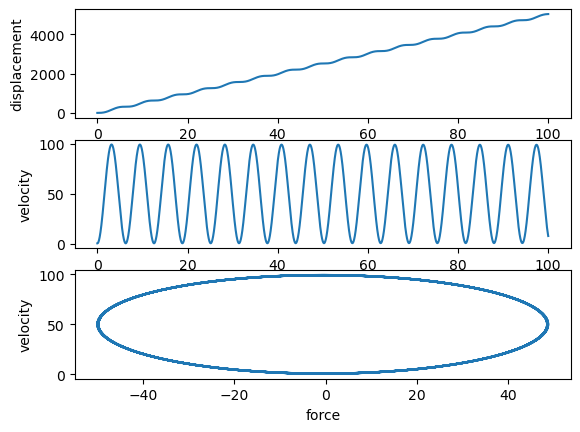

In [25]:
# x0 = [0, 0.5]
# tmax = 100
# nsteps = 4000
# t = np.linspace(0, tmax, nsteps)
# par.m = 1
# par.k = 1
# par.v0 = 50
# x = ode_solver_scipy(x0, t, par)
# force = par.k * (x[:,0] - t * par.v0)

# fig, axes = plt.subplots(3,1)

# axes[0].plot(t, x[:,0])
# axes[0].set_xlabel('time')
# axes[0].set_ylabel('displacement')

# axes[1].plot(t, x[:,1])
# axes[1].set_xlabel('time')
# axes[1].set_ylabel('velocity')

# axes[2].plot(force, x[:,1])
# axes[2].set_xlabel('force')
# axes[2].set_ylabel('velocity')

In [26]:
def rs_friction(mu0, vel, v0, a, b, Dc, theta): 
    #fric = mu0+a*np.log(vel/v0) + b *np.log(theta/(Dc/v0))
    fric= a * np.arcsinh(vel/(2 * v0) * np.exp((mu0 + b * np.log(v0 * theta/Dc))/a))
    return fric 

@dataclass
class rs_parameters:
    m :float = 1 # mass
    k :float = 1 # spring stiffness
    mu_0 :float = 0.6
    a :float = 0.01
    b :float = 0.03
    Dc :float = 5
    v0 :float = 1
    sn :float = 1

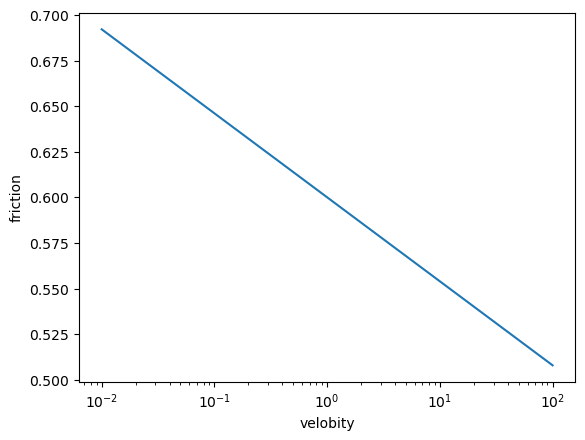

In [27]:
par = rs_parameters()
nstep = 100
vel = np.linspace(par.v0/100,par.v0*100,nstep)
fric = rs_friction(par.mu_0,vel,par.v0,par.a,par.b,par.Dc,par.Dc/vel)
plt.semilogx(vel,fric);plt.xlabel('velobity');plt.ylabel('friction')
plt.show()

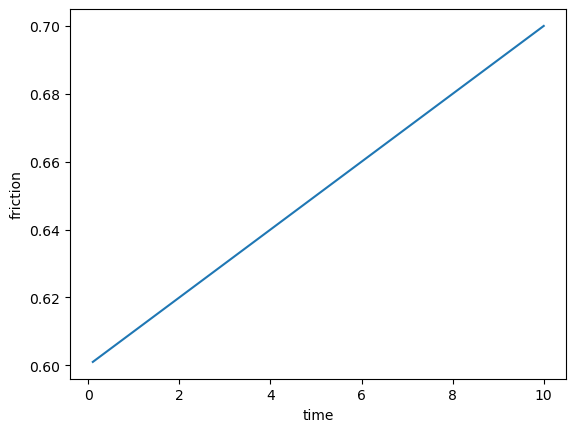

In [28]:
vel = np.zeros(nstep)
time = np.linspace(0.1,10,nsteps)
theta = .6+time*0.01
fric = rs_friction(par.mu_0,0,par.v0,par.a,par.b,par.Dc,theta)
plt.plot(time,theta);plt.xlabel('time');plt.ylabel('friction')
plt.show()

Let's set up the equations for a spring-slider system with the RSF formulation for ${\bf x} = \{x,y,\theta,x_{load}\}$, with $y=\dot{x}$, 

\begin{align}
\dot{x} &= y\\
\dot{y} &= -\frac{k(x-x_{load})+\mathrm{sgn}(y)\sigma_n\mu(y,\theta))}{m}\\
\dot{\theta} &= 1 - \frac{y\theta}{D_c}\\
\dot{x}_{load} &= v_0\\
\end{align}

For the sake of pysr we need to know the entire equation that is be estimated and ot have it in pieces, so we should replace $\mu$ with the rs friction law above:

<!--     fric= a * np.arcsinh(vel/(2 * v0) * np.exp((mu0 + b * np.log(v0 * theta/Dc))/a)) -->

\begin{align}
\dot{y} &= -\frac{k(x - x_{load}) + \mathrm{sgn}(y)\sigma_n [a \arcsin (\frac{v}{2 v_0} \exp (\mu_0 + b \log(v_0 \frac{\theta}{D_c}))])}{m}
\end{align}

<!-- why isnt mathjax working -->

parameters that will be estimated by pysr will be

| variable | desc |
| -------- | ---- |
| k | |
| sgn(y) | |
| a | |
| b | |

The variables that pysr needs is as input data is

| variable | desc |
| -------- | ---- |
| ydot | |
| x | |
| x_load | |
|v | |
| v_0 | |
| mu_0 | |
| theta | |
| Dc | |

In [35]:
def dxdt(x, t, m, k, mu_0, a, b, Dc, v0, sn): 
    vel = np.asarray(x[1])
    state = np.asarray(x[2])
    load_loc = np.asarray(x[3])
    
    # this is where we make the loading a bit more interesting
    if(t > 10):
        vload = v0/1e5
    elif(t > 3):
        vload = v0 
    else:
        vload = v0
        
    f0 = x[1] # velocity 
    
    # rate and state friction
    rs_fric = rs_friction(mu_0, vel, v0, a, b, Dc, state)
    
    # acceleration
    f1 = - (k * (x[0] - load_loc) - np.sign(vel) * par.sn * rs_fric)/m 
    
    # state variable
    f2 = 1 - vel * state/Dc # evolution law
    
    # velocity
    f3 = vload
    return [f0, f1, f2, f3]

In [33]:
par = rs_parameters()
x0 = [0, par.v0, par.Dc/par.v0, 0]
tmax = 20
nsteps = 4000
t = np.linspace(0, tmax, nsteps)
par.k = 20
par.m = .1
par.sn = 1e2
par.v0 = 1e2
# x = ode_solver_scipy(x0, t, par)
x = integrate.odeint(dxdt, x0, t, astuple(par), rtol=1e-12)

displacement = x[:,0]
velocity = x[:,1]
state = x[:,2]
loadpoint_displacement = x[:,3]
force = par.k * (loadpoint_displacement - displacement) # loading force
fric = rs_friction(par.mu_0, velocity, par.v0, par.a, par.b, par.Dc, state)§

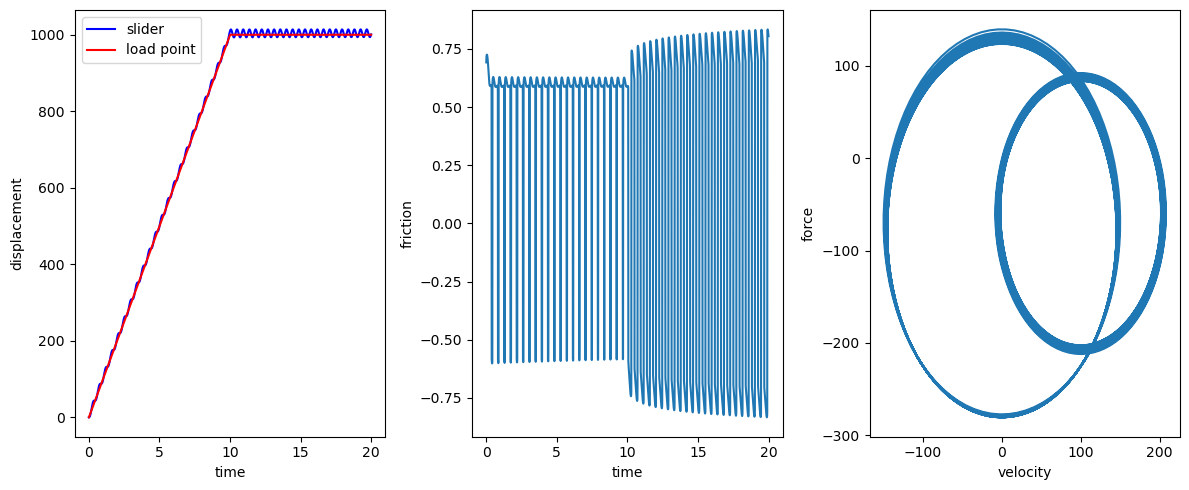

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

axes[0].plot(t, displacement, color='blue', label='slider')
axes[0].plot(t, loadpoint_displacement, color='red', label='load point')
axes[0].set_xlabel('time')
axes[0].set_ylabel('displacement')
axes[0].legend()

axes[1].plot(t, fric)
axes[1].set_xlabel('time')
axes[1].set_ylabel('friction')

axes[2].plot(velocity, force)
axes[2].set_xlabel('velocity')
axes[2].set_ylabel('force')

fig.tight_layout()